# Testing Notebook

This notebook is intended for testing, to ensure HelioCloud capabilities are all in place. The items it tests are:

1) Ability to import core PyHC packages (container test)
2) Ability to access HelioCloud data listings via cloudcatalog
3) Ability to read FITS, CDF and NetCDF files from S3 storage (S3 test, container test)
4) Ability to run a task with Lambdas (lambdas test)
5) Ability to plot data using matplotlib (plotting test)
6) Ability to save data locally, then read it back (permissions test)
7) Ability to run very basic functions from PyHC core packages HAPI, SunPy, Kamodo, PlasmaPy, pySat, PySpedas, and SpacePy
8) Ability to spin up a Dask cluster to run a task (dask test)

In [1]:
%pip install cloudcatalog

Note: you may need to restart the kernel to use updated packages.


In [2]:
## Container test
import cloudcatalog
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits
import astropy.units as u
import cdflib
import xarray as xr
# S3
import boto3
import s3fs
# utilities
import io
import math
import logging
import time
import re
import pickle
# PyHC core as of 2023
from hapiclient import hapi
from hapiplot import hapiplot
import sunpy.map
import sunpy.data.sample  
from kamodo import Kamodo
import spacepy.toolbox as tb
from plasmapy.formulary import beta
import pysat
import pyspedas
from pytplot import tplot, get_data
# Dask
import dask
from dask.distributed import Client
from dask_gateway import Gateway, GatewayCluster

imports_loaded_flag = True

In [3]:
# optional, prettier inline Notebook plotting
%matplotlib inline
%config InlineBackend.figure_formats = ['svg'] 

# HelioCloud shared cloud file registry (cloudcatalog)

This is a simple standard for any dataset that enables users to access it via an API or directly.  The short definition is:
    * S3 disks have a 'catalog.json' describing their datasets
    * Each dataset has a <dataid>_YYYY.csv index file of its contents
    * These indexes have the form "time, s3_location, filesize" (plus optional metadata)

In [6]:
if 'imports_loaded_flag' not in locals():
    import cloudcatalog
cr=cloudcatalog.CatalogRegistry()
fr=cloudcatalog.CloudCatalog("s3://gov-nasa-hdrl-data1/")
frID = "aia_0094"
myjson = fr.get_entry(frID)
start, stop = myjson['start'], myjson['stop']
file_registry1 = fr.request_cloud_catalog(frID, start_date=start, stop_date=stop, overwrite=False)
# And convert that richer data to a list of files to process
filelist = file_registry1['datakey'].to_list()
assert len(filelist) == 1624900

## FITS, CDF and NetCDF reading off S3

We now read one FITS file from the above list and print a simple sum of it to show we read it properly.  We use the 's3fs' protocol to bring it into AstroPy's FITS reader.  Some versions of astropy already can read S3 files directly.  Here we use "import astropy.fits" and "import s3fs" for FITS; "import cdflib" for CDF; and "import xarray as xr" and "import s3fs" for NetCDF.

In [7]:
if 'imports_loaded_flag' not in locals():
    import astropy.io.fits
    import s3fs
try:
    s3name = filelist[1]
except:
    # hard-coded file in case we skipped fetching lists via cloudcatalog
    s3name = "s3://gov-nasa-hdrl-data1/sdo/aia/20100513/0094/sdo_aia_h2_20100513T000000_0094_v1.fits"
fs=s3fs.S3FileSystem(anon=False)
fgrab = fs.open(s3name)
hdu = astropy.io.fits.open(fgrab)
print(hdu[0].header[0:10])
hdu.info()
assert sum(sum(hdu[1].data)) == 28549945
fgrab.close() # clean up at the end

SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                   16 / number of bits per data pixel                  NAXIS   =                    0 / number of data axes                            EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [8]:
# CDF reading from S3 cloud
if 'imports_loaded_flag' not in locals():
    import cdflib
s3name="s3://helio-public/skantunes/mms_fgm.cdf"
cdfin1=cdflib.CDF(s3name)
#print(cdfin1.cdf_info())
assert math.isclose(sum(sum(cdfin1['mms1_fgm_b_gse_brst_l2'])), 415662.265625)
cdfin1.close()
# Can also do CDF reading in a URL, noted here but not run
#urlname="https://helio-public.s3.amazonaws.com/skantunes/mms_fgm.cdf"
#cdfin2=cdflib.CDF(urlname)
#print(cdfin2.cdf_info())
#cdfin2.close()

In [9]:
# NetCDF via xarray, using s3fs, reading from S3 cloud
if 'imports_loaded_flag' not in locals():
    import s3fs
    import xarray as xr
s3name="s3://helio-public/skantunes/guvi_spect.nc"
fs=s3fs.S3FileSystem(anon=False)
fgrab = fs.open(s3name)
dataset = xr.open_dataset(fgrab)
#dataset.info()
assert math.isclose(sum(dataset['DISKCOUNTSDATA_DAY'].data[:,0]),4384917.771728516)
dataset.close()
fgrab.close()

## Ability to run a task with Lambdas (lambdas test) 

In [10]:
if 'imports_loaded_flag' not in locals():
    import cloudcatalog
cr = cloudcatalog.CatalogRegistry()
endpoint = cr.get_endpoint('GSFC HelioCloud Public Temp')
fr = cloudcatalog.CloudCatalog(endpoint, cache=False)
dataset_id1 = 'mms1_feeps_brst_electron'
start = '2020-02-01T00:00:00Z'
stop =   '2020-02-02T00:00:00Z'
file_registry1 = fr.request_cloud_catalog(dataset_id1, start_date=start, stop_date=stop, overwrite=False)

print('Python Hash of File | Start Date | File Size')
fr.stream(file_registry1, lambda bo, d, f: print(hash(bo.read()), d.replace(' ', 'T')+'Z', f))

Python Hash of File | Start Date | File Size
1376491853518835690 2020-02-01T07:55:23Z 1521034
5491157673017471661 2020-02-01T08:17:13Z 3166628
-5348412142488517005 2020-02-01T08:19:23Z 3166628
7977086856465852583 2020-02-01T08:21:33Z 3166628
-5196188155694115164 2020-02-01T08:23:43Z 3396580
-731025062583840296 2020-02-01T08:26:03Z 3166628
-7634349209802079520 2020-02-01T08:28:13Z 3159442
5808490082298449664 2020-02-01T08:30:23Z 3152256
2081896028699209590 2020-02-01T08:37:13Z 3396580
8847885322320268240 2020-02-01T08:39:33Z 3396580
1770072458171512595 2020-02-01T08:41:53Z 3403766
1386982618651511942 2020-02-01T08:44:13Z 3396580
-956998716608619674 2020-02-01T08:46:33Z 3396580
155320824779457345 2020-02-01T08:48:53Z 3389394


## Ability to plot data using matplotlib (plotting test)

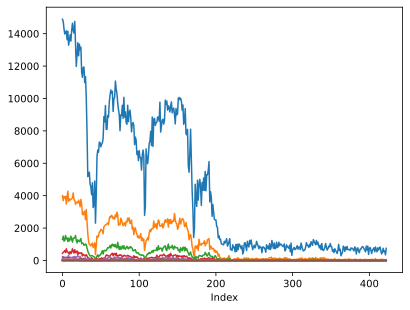

In [11]:
if 'imports_loaded_flag' not in locals():
    import cdflib
    import matplotlib.pyplot as plt
s3key = 's3://helio-public/MMS/mms1/feeps/brst/l2/electron/2020/02/mms1_feeps_brst_l2_electron_20200201081713_v6.1.1.cdf'
cdf = cdflib.CDF(s3key)
var_data = cdf.varget(1)
plt.figure()
plt.plot(var_data)
plt.xlabel("Index")
plt.show()

# Ability to save data locally, then read it back (permissions test)

In [12]:
if 'imports_loaded_flag' not in locals():
    import pickle
sample_data = [0, 3, 9]
with open('test.pickle','wb') as fout:
    pickle.dump(sample_data, fout)
with open('test.pickle','rb') as fin:
    new_data = pickle.load(fin)
assert new_data == sample_data

## PyHC package tests

Tests HAPI, SunPy, Kamodo, PlasmaPy, pySat, PySpedas, and SpacePy using very brief excerpts of the examples from either their website tutorials or from the 2022 PyHC Summer School.

### HAPI
Test from 2022 PyHC Summer School. Requires "from hapiclient import hapi; from hapiplot import hapiplot", also "import math" for the assertion math.isclose() function.

hapi(): Running hapi.py version 0.2.5
hapi(): file directory = ./hapicache/cdaweb.gsfc.nasa.gov_hapi
hapi(): Reading OMNI2_H0_MRG1HR_DST1800,Proton_QI1800_20211025T000000_20211201T000000.pkl
hapi(): Reading OMNI2_H0_MRG1HR_DST1800,Proton_QI1800_20211025T000000_20211201T000000.npy 


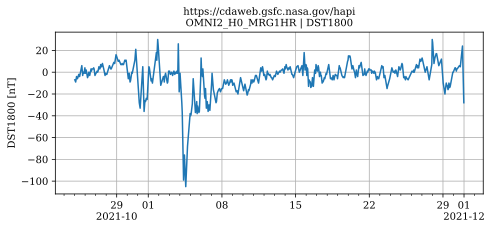

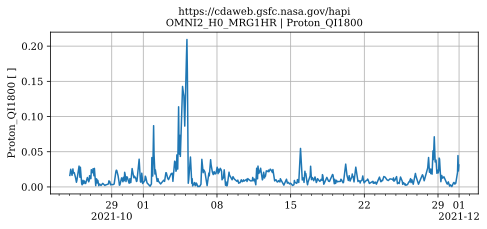

In [19]:
if 'imports_loaded_flag' not in locals():
    from hapiclient import hapi
    from hapiplot import hapiplot
    import math
# HAPI test, OMNIWeb data
# The data server
server     = 'https://cdaweb.gsfc.nasa.gov/hapi'
# The data set
dataset    = 'OMNI2_H0_MRG1HR'
# Start and stop times
start      = '2021-10-25T00:00:00Z'
stop       = '2021-12-01T00:00:00Z'
# The HAPI convention is that parameters is a comma-separated list. Here we request two parameters.
parameters = 'DST1800,Proton_QI1800'
# Configuration options for the hapi function.
opts = {'logging': True, 'usecache': True, 'cachedir': './hapicache' }
# Get parameter data. See section 5 for for information on getting available datasets and parameters
data, meta = hapi(server, dataset, parameters, start, stop, **opts)
hapiplot(data, meta)
assert meta['startDate'] == '1970-01-01T00:00:00Z'

### SunPy
Test from https://docs.sunpy.org/en/stable/tutorial/maps.html.  Requires "import sunpy.map" and "import sunpy.data.sample", also "import math" for the assertion math.isclose() function.

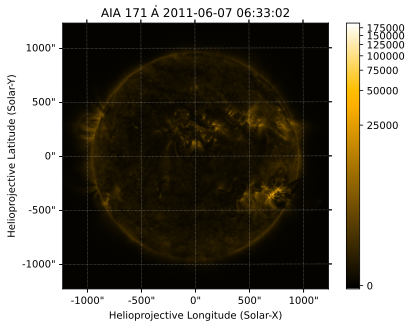

Mean of image: 427.02252


In [20]:
if 'imports_loaded_flag' not in locals():
    import sunpy.map
    import sunpy.data.sample
sunpy.data.sample.AIA_171_IMAGE
my_map = sunpy.map.Map(sunpy.data.sample.AIA_171_IMAGE)  
my_map.quicklook()  # is quicklook doing anything? I do not see a plot
fig = plt.figure()
ax = fig.add_subplot(projection=my_map)
my_map.plot(axes=ax)
plt.colorbar()
plt.show()
print("Mean of image:",my_map.data.mean())
assert math.isclose(my_map.data.mean(),427.02252,rel_tol=1e-8)

### Kamodo
From 2022 PyHC Summer School, notebooks 03 and 04. Requires "from kamodo import Kamodo" and, for making an example dataset, "import numpy as np".

In [21]:
if 'imports_loaded_flag' not in locals():
    from kamodo import Kamodo
    import numpy as np
x, y, z = np.meshgrid(np.linspace(-2,2,4),
                      np.linspace(-3,3,6),
                      np.linspace(-5,5,10))
points = np.array(list(zip(x.ravel(), y.ravel(), z.ravel())))
def fvec_Ncomma3(rvec_Ncomma3 = points):
    return rvec_Ncomma3
k = Kamodo(fvec_Ncomma3 = fvec_Ncomma3)
k.plot('fvec_Ncomma3')
#
k_test = Kamodo('f(x[cm])[kg/m^3]=x^2-x-1')
assert k_test.f(3) == 3**2 - 3 - 1

### SpacePy
SpacePy Toolbox example from their quickstart guide, https://spacepy.github.io/quickstart.html.  Requires "import spacepy.toolbox as tb", also "import numpy as np" for generating the same dataset, also "import math" for the assertion math.isclose() function.

In [31]:
if 'imports_loaded_flag' not in locals():
    import spacepy.toolbox as tb
    import numpy as np
    import math
a = {'entry1':'val1', 'entry2':2, 'recurse1':{'one':1, 'two':2}}
tb.dictree(a)
dat = np.arange(100)
bh = tb.binHisto(dat)
print(bh)
assert math.isclose(bh[0], 21.328903431315652)
assert bh[1] == 5.0

+
|____entry1
|____entry2
|____recurse1
     |____one
     |____two
(21.328903431315652, 5)


## PlasmaPy
Example from 2022 PyHC summer school. Requires "from plasmapy.formulary import beta"(alt: "from plasmapy.formulary import \*"), also "import astropy.units as u" for setup and "import math" for the assertion math.isclose() function

In [33]:
if 'imports_loaded_flag' not in locals():
    from plasmapy.formulary import beta
    import astropy.units as u
    import math
# Let's start by defining some plasma parameters for an active region in the solar corona.
# When we use these parameters in beta, we find that β is quite small so that the corona is magnetically dominated.
B_corona = 50 * u.G
n_corona = 1e9 * u.cm ** -3
T_corona = 1 * u.MK
b=beta(T_corona, n_corona, B_corona)
assert math.isclose(b, 0.0013879797625431325, rel_tol=1e-20)

### pySat
Example taken from their quickstart guide, https://pysat.readthedocs.io/en/latest/quickstart.html. Requires "import pysat".

In [34]:
if 'imports_loaded_flag' not in locals():
    import pysat
# Testing out the xarray installation
inst = pysat.Instrument('pysat', 'testing_xarray')
inst.load(2009, 1)
assert sum(inst.data['dummy1'].values) == 984406

21-Nov-23 20:43:38: /srv/conda/envs/notebook/lib/python3.10/site-packages/pysat/_files.py:581: FutureWarning:

The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.






### PySpedas
Requires "import pyspedas" and "from pytplot import tplot, get_data", also "import math" for the assertion math.isclose() function.

In [35]:
if 'imports_loaded_flag' not in locals():
    import pyspedas
    from pytplot import tplot, get_data
    import math
time_range = ['2020-04-20/06:00', '2020-04-20/08:00']
pyspedas.solo.mag(trange=time_range, time_clip=True)
pyspedas.mms.fgm(trange=time_range, time_clip=True, probe=2)
tplot(['B_RTN','mms2_fgm_b_gsm_srvy_l2_bvec'])
mag_data = get_data('mms2_fgm_b_gse_srvy_l2_bvec')
assert math.isclose(sum(sum(mag_data.y)),152229.33203125)

21-Nov-23 20:43:43: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/solar-orbiter/mag/science/l2/rtn-normal/2020/
21-Nov-23 20:43:44: File is current: solar_orbiter_data/mag/science/l2/rtn-normal/2020/solo_l2_mag-rtn-normal_20200420_v01.cdf
21-Nov-23 20:43:46: Time clip was applied to: B_RTN
21-Nov-23 20:43:46: Loading pydata/mms2/fgm/srvy/l2/2020/04/mms2_fgm_srvy_l2_20200420_v5.239.0.cdf
21-Nov-23 20:43:52: Time clip was applied to: mms2_fgm_b_gse_srvy_l2
21-Nov-23 20:43:53: Time clip was applied to: mms2_fgm_b_gsm_srvy_l2
21-Nov-23 20:43:54: Time clip was applied to: mms2_fgm_b_dmpa_srvy_l2
21-Nov-23 20:43:55: Time clip was applied to: mms2_fgm_b_bcs_srvy_l2
21-Nov-23 20:43:56: Time clip was applied to: mms2_fgm_flag_srvy_l2
21-Nov-23 20:43:56: Time clip was applied to: mms2_fgm_r_gse_srvy_l2
21-Nov-23 20:43:56: Time clip was applied to: mms2_fgm_r_gsm_srvy_l2
21-Nov-23 20:43:57: Time clip was applied to: mms2_fgm_hirange_srvy_l2
21-Nov-23 20:43:58: Time clip was applie

# Dask cluster 'burst' test

We now use 4 cells to run a Dask cluster 'burst' test, sending 1000 files out to multiple worker nodes using Dask.  This can take up to 10 minutes to spin up the Cluster, but then this and subsequent jobs are very rapid.
Cell 1 sets up the data environment. Cell 2 starts the cluster.  Cell 3 does the dask run (and can be re-run).  Cell 4 shuts down the cluster for good.

In [36]:
if 'imports_loaded_flag' not in locals():
    import cloudcatalog
    import boto3
    import dask
    import io
    import time
    import re
    import astropy.io.fits
    from dask.distributed import Client
    from dask_gateway import Gateway, GatewayCluster
    
def DO_SCIENCE(mydata):
    # you can put better science here
    iirad = mydata.mean()
    return iirad

def process_fits_s3(s3key:str): # -> Tuple[str, float]:
    """ grabs an S3 file then runs DO_SCIENCE() on it """
    sess = boto3.session.Session() # do this each open to avoid thread problem 'credential_provider'
    s3c = sess.client("s3")
    [mybucket,mykey] = re.sub(r"s3://","",s3key).split("/",1)
    try:
        fobj = s3c.get_object(Bucket=mybucket,Key=mykey)
        rawdata = fobj['Body'].read()
        bdata = io.BytesIO(rawdata)
        hdul = astropy.io.fits.open(bdata,memmap=False)        
        date = hdul[1].header['T_OBS']
        irrad = DO_SCIENCE(hdul[1].data)
    except:
        print("Error fetching ",s3key)
        date, irrad = None, None       
    return date, irrad

if 'file_registry1' not in locals():
    file_registry1 = fr.request_cloud_catalog(frID, start_date=start, stop_date=stop, overwrite=False)
filelist = file_registry1['datakey'].to_list()
s3_files = filelist[0:1000] # small test set to test

In [37]:
""" Now we initialize the Dask gateway and cluster, using your above parameters, to set up the virtual machines that will subsequently operate on the data. We use some non-optimized Dask parameters for setting up the run."""
# from the daskhub tutorial, setting up dask
gateway = Gateway()
options = gateway.cluster_options()
options.worker_cores = 4
options.worker_memory = 2
# initialize cluster and create client, takes < 15 seconds
cluster = gateway.new_cluster(options)
client = cluster.get_client() # can also use 'client=Client(cluster)'
cluster.adapt(minimum=1, maximum=4)
# if useGUI: cluster
# client # let us take a look at it

21-Nov-23 20:44:02: /srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/platform/asyncio.py:193: DeprecationWarning:

There is no current event loop




In [38]:
now=time.time()
time_irrad = client.map(process_fits_s3, s3_files) # do it
all_data = client.gather(time_irrad) # gather results
print("Done! Completed in time ",(time.time()-now)/60.0,"minutes, on",len(all_data),"files")

Done! Completed in time  2.752697165807088 minutes, on 14 files


In [39]:
# always shutdown once all cluster uses and re-uses are over
cluster.shutdown()

In [40]:
print("Done all tests")

Done all tests
